In [39]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torchmetrics import MetricCollection, AUROC, CalibrationError, SumMetric, Accuracy
import wandb
from utils_datamodel.wandb_utils import load_model, parse_runs, wandb_table_to_dataframe
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback

from src.ess import SemiSubEllipticalSliceSampling
import os
from src.base_models import RegNet, NllLoss
from src.semiSub_model import getModel
from src.pyro_models import pyroSemiSubspace
from src.semi_sub_utils import get_curve_space_torch, span_space_from_curve_model
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from tqdm.notebook import tqdm
from functools import partial
import torch.distributions as dist
from sklearn.model_selection import StratifiedKFold
from numpyro.diagnostics import summary
from src.semi_sub_utils import features, get_ds_test_from_df, get_ds_from_df, base_net_kwargs, expCollector, log_pointwise_predictive_likelihood
from src.semi_subspace import *
from utils_datamodel.utils import FastFillTensorDataLoader
from simulation_coverage import data_generation_simulation1
from src.plot import plot_subspace, exclude_project_code_dirs, run_metrics_on_samples, plot_predictive_regression, plot_curve_solutions_regression, plot_subspace_solution_regression, plot_data, plot_subspace_solution_regression_pyro


import pyro
from pyro.infer.autoguide import init_to_sample
from pyro.poutine.indep_messenger import IndepMessenger
from copy import deepcopy
import arviz as az

# %load_ext tensorboard
sns.set_style("darkgrid")
if torch.cuda.is_available() and 1:
    print("Use cuda. Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device('cuda', torch.cuda.current_device())
else:
    device = torch.device('cpu')
print("Device: ", device)
%load_ext autoreload
%autoreload 2
%env WANDB_BASE_URL http://141.37.176.203:8080
%env WANDB_NOTEBOOK_NAME ./semi_regression_train.ipynb

wandb_project = 'reg_semi_small_split_4dimSpace'
use_ortho = False
seed = 0


def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

# figsize = get_figsize(234*4.4)
# tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     # "text.latex.preamble": r'\usepackage{amsfonts}',
#     "font.family": "Nimbus Sans",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 24,
#     "font.size": 24,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 18,
#     "xtick.labelsize": 24,
#     "ytick.labelsize": 24
# }
# figsize = get_figsize(234*2)

fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize = [fig_width,fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize":figsize
}
plt.rcParams.update(tex_fonts)

Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: WANDB_BASE_URL=http://141.37.176.203:8080
env: WANDB_NOTEBOOK_NAME=./semi_regression_train.ipynb
Figure size= [3.2489276324892766, 2.0079477038671003]


## data geneartion

f_mean = [-0.18565409  6.460015  ]
f_std = [2.5348663 4.450509 ]


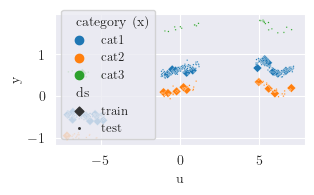

In [2]:
# kwargs = {"dimensions": [200, 50, 50, 50],
use_ortho = False
base_net_kwargs = {"dimensions": [16, 16],
                   "output_dim": 1,
                   "input_dim": 2}
outcome_dist = pyro.distributions.Normal  # outcome distributions
loss_fn = NllLoss(outcome_dist,
                  constrains={'loc': torch.nn.Identity()},
                  scale=.05,
                  reduction='mean')
net_kwargs = dict(lr=1e-3,
                  weight_decay=1e-5,
                  loss_fn=loss_fn,
                  num_structure=2,
                  ortho_layer_name_nn_head="lin[4]" if use_ortho else None
                  )
exp_col = expCollector(wandb_project='semi_regression_v2',
                       use_ortho=use_ortho,
                       seed=10,
                       base_net_kwargs=base_net_kwargs,
                       net_kwargs=net_kwargs,
                       nll_fn=loss_fn,
                       max_epochs=3000)

df, df_test = prepare_data(exp_col, reload=False)
plt.figure(figsize=figsize)
plot_data(exp_col)
plt.tight_layout()

dataset, (f_mean, f_std) = get_ds_from_df(df, device)
exp_col.f_mean = f_mean  # store data mean and data std
exp_col.f_std = f_std
dataset_test = get_ds_test_from_df(df_test, device, f_mean, f_std)
torch.save(dict(dataset=dataset, mean=f_mean, std=f_std, dataset_test=dataset_test), "regression_TensorDataSet.ds")
cuda_loader = FastFillTensorDataLoader(dataset, batch_size=len(df), shuffle=True,
                                       pin_memory=False)
exp_col.train_dataloader = cuda_loader
cuda_loader_test = FastFillTensorDataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False,
                                            pin_memory=False)
exp_col.test_dataloader = cuda_loader_test

In [5]:
torch.save(dataset, "regression_TensorDataSet.ds")

## semi-subspace apporximation with small subspace dimension

### Create Projection matrix

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10


SemiAdditive
RegNet


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `valida

SemiAdditive


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=9000` reached.
wandb: Adding directory to artifact (./wandb/run-20230808_121227-85ntdgv0/files/checkpoints)... Done. 0.0s
Global seed set to 10


SemiAdditive


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(


SemiAdditiveSubspace
SemiAdditive
Subspace
RegNet


100%|██████████| 1600/1600 [00:01<00:00, 888.65it/s]


***************************
* Initialisation finished *
***************************


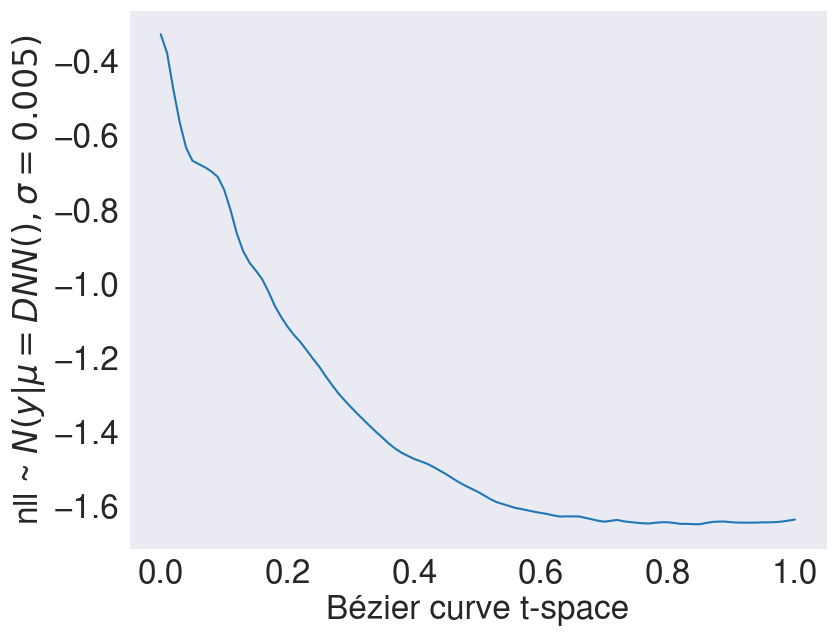

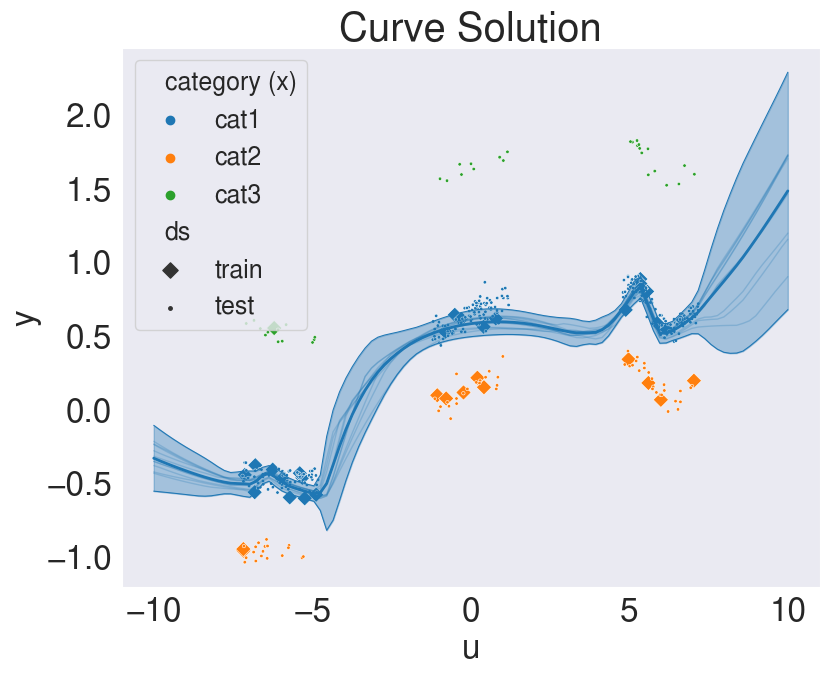

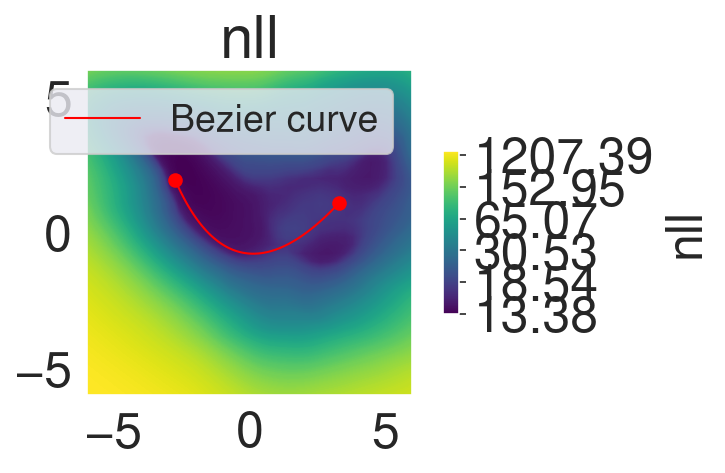

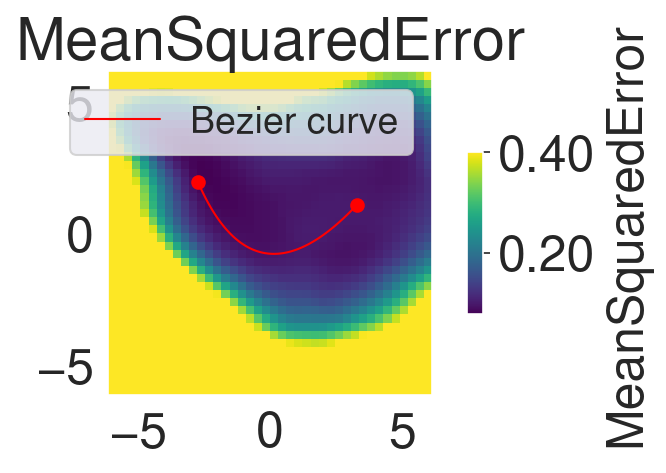

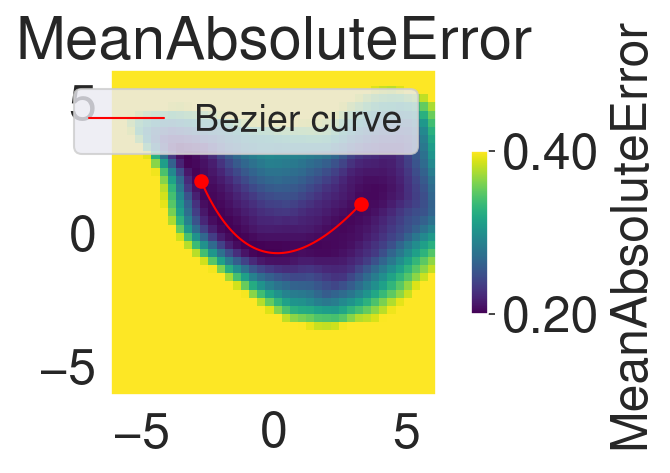

In [30]:
best_curve_model, wandb_curve_exp_id, _, wandb_logger = initialize_subspace_model_v2(
    exp_col=exp_col,
    plot_predictive_f=plot_predictive_regression,
    plot_curve_solution_f=plot_curve_solutions_regression)
wandb.finish()
print("*" * 27)
print("* Initialisation finished *")
print("*" * 27)

### Run HMC on the subspace

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10


SemiAdditive
RegNet
Name: model_curve, ID: 85ntdgv0
This run used following artifacts:
Last Acc None
loaded artifact: 
SemiAdditiveModel
model_state_85ntdgv0:v0


wandb:   1 of 1 files downloaded.  
Global seed set to 10


SemiAdditive
Instantiate semi subspace model for ess
SemiAdditiveSubspace
SemiAdditive
Subspace
RegNet
[[4.31941709e+00 3.74952424e+00 8.08188489e-16]]


Warmup [1]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [7]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [8]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [9]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [10]:   0%|          | 0/1200 [00:00, ?it/s]

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_k

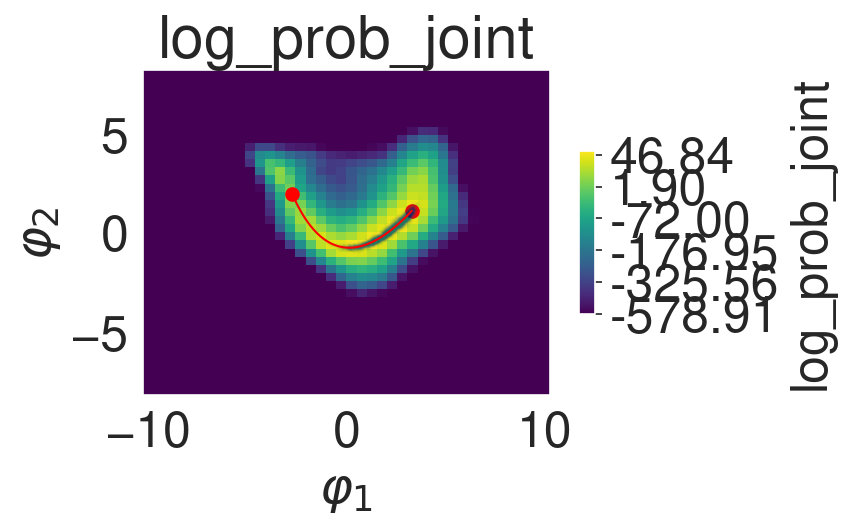

In [31]:
az_post_hmc, mcmc = run_hmc_on_subspace(num_chains=10, 
                                        num_warmup=400, 
                                        num_samples=800, 
                                        prior_scale=1.,
                                        exp_col=exp_col,
                                        curve_model=best_curve_model,
                                        curve_wandb_id=wandb_curve_exp_id)
pyro_model = mcmc.kernel.model

In [10]:
az.summary(az_post_hmc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
theta[0, 0] -0.498  0.018  -0.529   -0.461      0.001    0.000     869.0  \
theta[0, 1]  0.999  0.051   0.901    1.093      0.002    0.002     446.0   
varphi[0]    0.478  1.725  -2.112    3.110      0.258    0.184      43.0   
varphi[1]   -0.053  0.527  -0.772    0.791      0.074    0.053      61.0   

             ess_tail  r_hat  
theta[0, 0]     891.0   1.06  
theta[0, 1]     859.0   1.04  
varphi[0]        50.0   1.19  
varphi[1]       154.0   1.12

array([[<Axes: ylabel='theta\n0, 0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta\n0, 1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='varphi\n0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='theta\n0, 0', ylabel='varphi\n1'>,
        <Axes: xlabel='theta\n0, 1'>, <Axes: xlabel='varphi\n0'>,
        <Axes: xlabel='varphi\n1'>]], dtype=object)

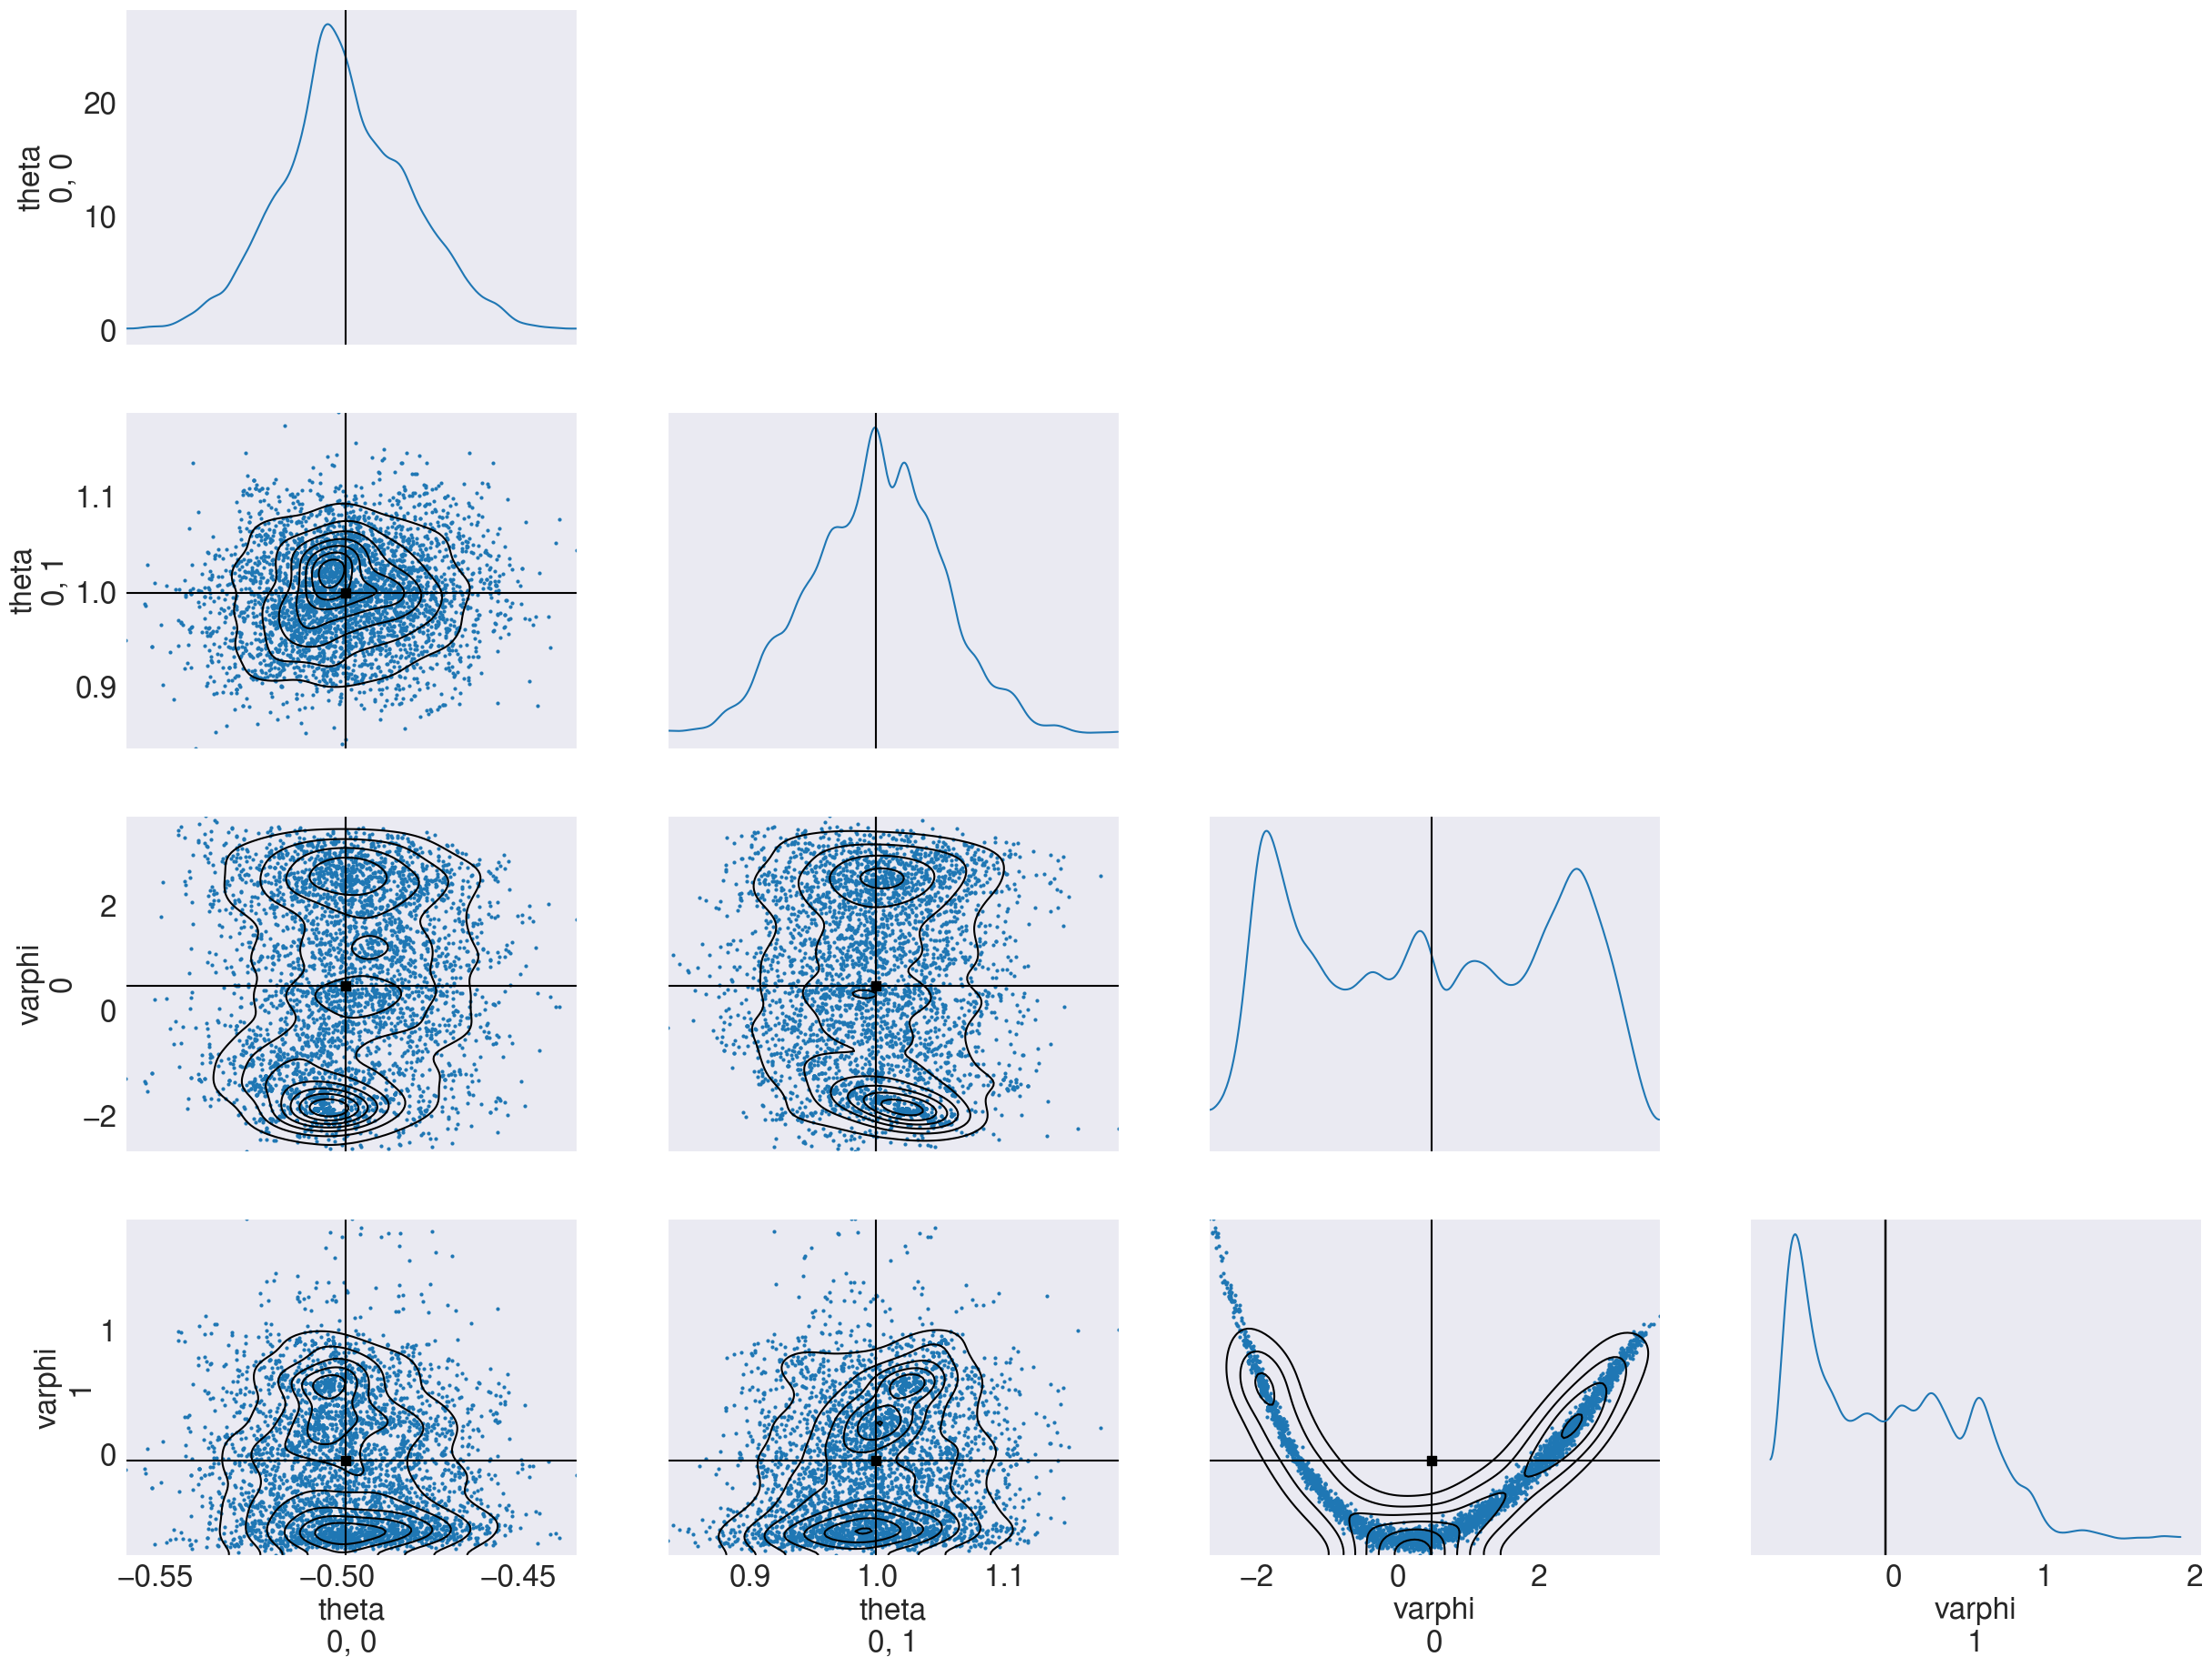

In [11]:
az.plot_pair(az_post_hmc,
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="mean",)

#### load samples and model

In [10]:
# load samples
exp_id = 'lty24vbr'
exp_col.num_bends = 3
art = wandb.Api().artifact(f'ddold/semi_regression_v2/data_{exp_id}:v0')
az_post_hmc= az.from_netcdf(art.file())

# load model state
art = wandb.Api().artifact(f'ddold/semi_regression_v2/model_state_{exp_id}:v0')
base_model = getModel(RegNet, seed=exp_col.seed, **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(device=device)
num_dnn_params = np.sum([p.numel() for p in base_model.dnn.parameters()])
pyro_model = pyroSemiSubspace(
    mean=torch.zeros(num_dnn_params, device=device, dtype=torch.float32),
    cov_factor=torch.zeros((2, num_dnn_params), device=device, dtype=torch.float32),
    sequential_dnn=base_model.dnn,
    module_structure=base_model.structure_lin,
    outcome_dist=exp_col.nll_fn.dist_)
pyro_model.load_state_dict(torch.load(art.file()))

# convert arviz samples back for pyro model
# samples = az_post_hmc.posterior.rename({
#         'theta' :'structure_nn.weight',
#         'theta_dim_0' :'structure_nn.weight_dim_0',
#         'theta_dim_1' :'structure_nn.weight_dim_1'})
# samples_pyro = {}
# for name in samples.data_vars:
#     var_samples = samples[name].to_numpy()
#     shape = (np.prod(var_samples.shape[:2]), *var_samples.shape[2:])
#     var_samples = var_samples.reshape(shape)
#     samples_pyro[name] = torch.from_numpy(var_samples).to(device=device)
pyro_model
test_lppd_k2 = wandb.Api().run(f'ddold/semi_regression_v2/{exp_id}').summary['test_lppd']
test_lppd_k2

Global seed set to 10


SemiAdditive
RegNet


415.273193359375

## increase subspace dimension

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10


SemiAdditive
RegNet


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `valida

SemiAdditive


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=9000` reached.
wandb: Adding directory to artifact (./wandb/run-20230808_122311-3icrzxku/files/checkpoints)... Done. 0.0s
Global seed set to 10


SemiAdditive


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(


SemiAdditiveSubspace
SemiAdditive
Subspace
RegNet


100%|██████████| 1600/1600 [00:01<00:00, 939.54it/s]


***************************
* Initialisation finished *
***************************


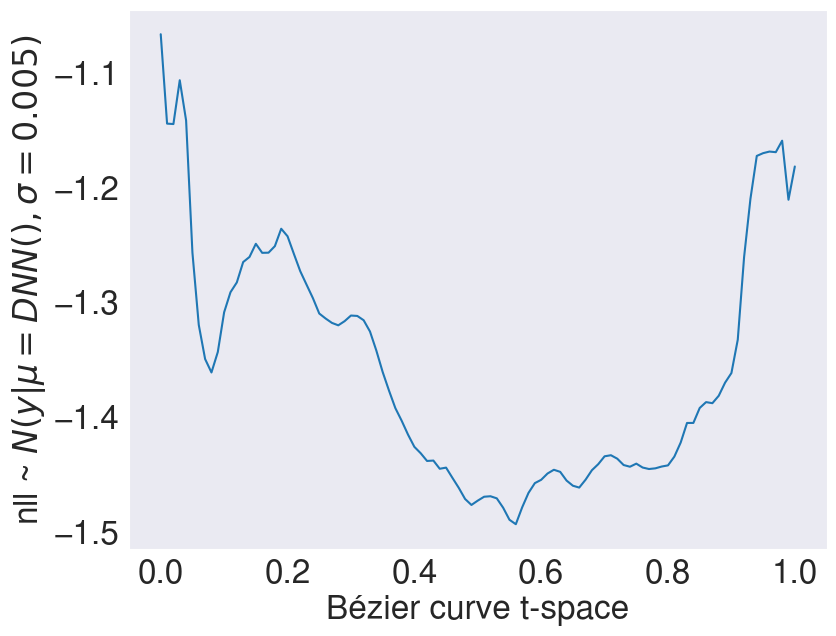

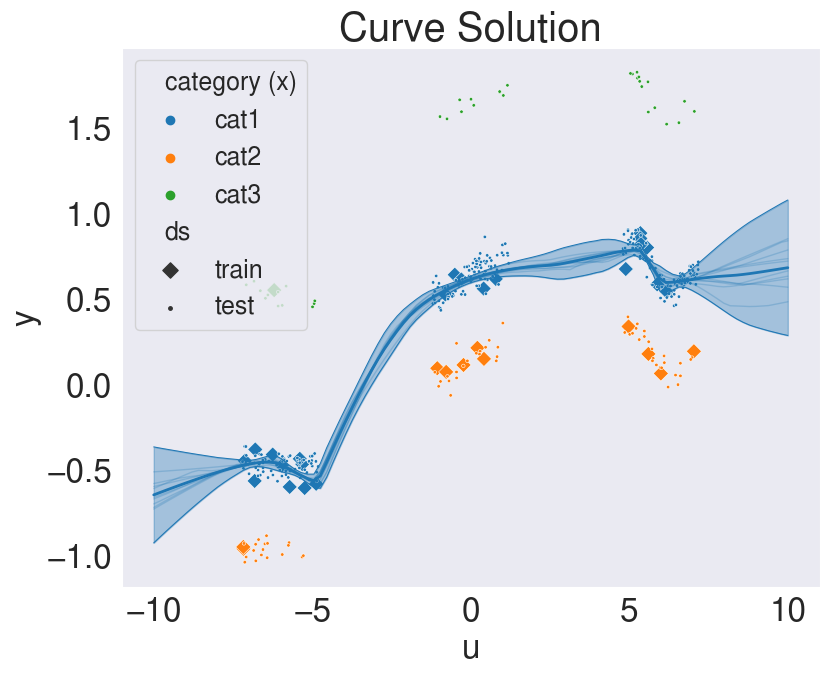

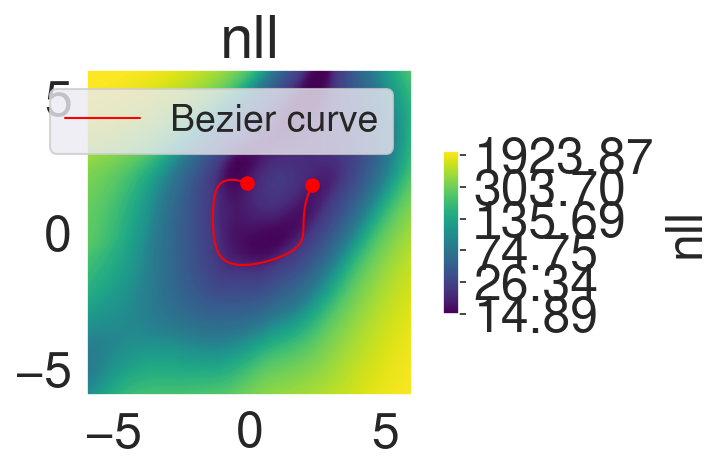

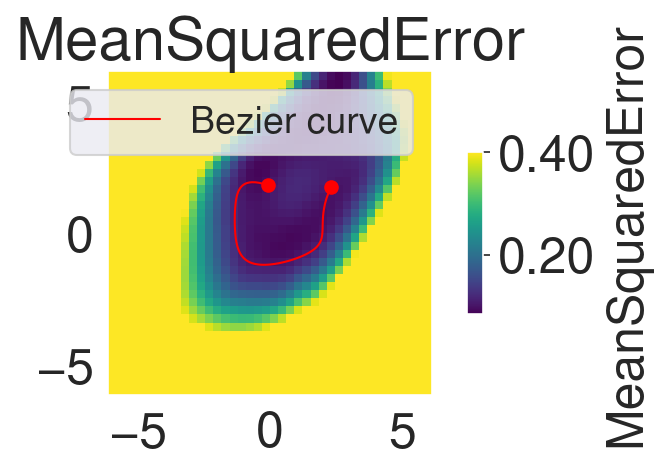

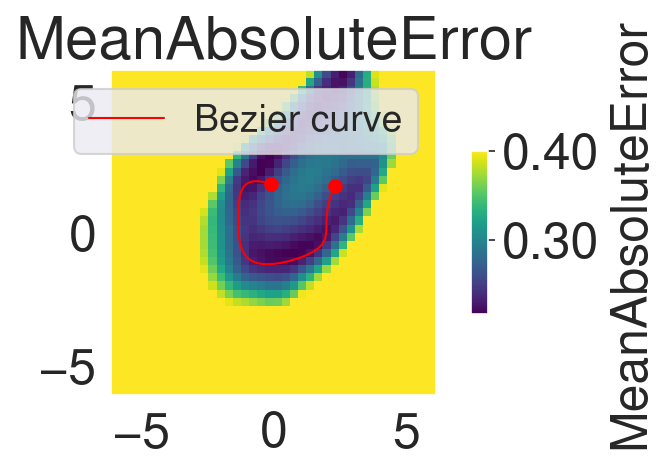

In [32]:
exp_col.num_bends = 13
exp_col.max_epochs = 3000
exp_col.net_kwargs['lr'] = 0.0005
best_curve_model, wandb_curve_exp_id, _, wandb_logger = initialize_subspace_model_v2(
    exp_col=exp_col,
    plot_predictive_f=plot_predictive_regression,
    plot_curve_solution_f=plot_curve_solutions_regression)
wandb.finish()
print("*" * 27)
print("* Initialisation finished *")
print("*" * 27)

In [33]:
az_post_hmc_12, mcmc_12 = run_hmc_on_subspace(num_chains=10, 
                                        num_warmup=400, 
                                        num_samples=800, 
                                        prior_scale=1.,
                                        exp_col=exp_col,
                                        curve_model=best_curve_model,
                                        curve_wandb_id=wandb_curve_exp_id)

pyro_model_12 = mcmc_12.kernel.model

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10
wandb:   1 of 1 files downloaded.  


SemiAdditive
RegNet
Name: model_curve, ID: 3icrzxku
This run used following artifacts:
Last Acc None
loaded artifact: 
SemiAdditiveModel
model_state_3icrzxku:v0


Global seed set to 10


SemiAdditive
Instantiate semi subspace model for ess
SemiAdditiveSubspace
SemiAdditive
Subspace
RegNet
[[5.82449320e+00 4.95830755e+00 4.52590740e+00 4.30697603e+00
  4.01323523e+00 3.90799779e+00 3.86069199e+00 3.62607910e+00
  3.45843847e+00 3.38553934e+00 3.26564886e+00 2.96342383e+00
  9.42645281e-16]]


Warmup [1]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [7]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [8]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [9]:   0%|          | 0/1200 [00:00, ?it/s]

Warmup [10]:   0%|          | 0/1200 [00:00, ?it/s]

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_k

In [34]:
az.summary(az_post_hmc_12)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
theta[0, 0] -0.477  0.023  -0.521   -0.434      0.002    0.001     194.0  \
theta[0, 1]  1.000  0.065   0.880    1.123      0.006    0.004     136.0   
varphi[0]   -0.423  2.098  -4.492    3.109      0.597    0.433      13.0   
varphi[1]    1.373  2.077  -2.256    4.745      0.587    0.425      13.0   
varphi[2]   -0.629  2.624  -4.333    4.093      0.763    0.553      12.0   
varphi[3]   -0.892  3.391  -7.783    3.693      1.027    0.747      12.0   
varphi[4]   -2.240  2.696  -7.195    2.186      0.794    0.576      12.0   
varphi[5]   -0.693  2.459  -4.778    3.630      0.701    0.508      13.0   
varphi[6]    0.552  2.200  -3.037    4.111      0.634    0.459      13.0   
varphi[7]    0.460  1.305  -1.778    2.601      0.312    0.224      19.0   
varphi[8]    2.076  3.367  -4.296    8.023      1.019    0.741      11.0   
varphi[9]    2.648  2.656  -2.138    6.502      0.778    0.565      12.0   
varphi[10]  -1.156  1.624  -4.873    1.784      0.444    0.321      14.0   
varphi[11]   0.369  2.382  -4.077    4.416      0.691    0.501      13.0   

             ess_tail  r_hat  
theta[0, 0]    3212.0   1.04  
theta[0, 1]     272.0   1.05  
varphi[0]        20.0   2.24  
varphi[1]        26.0   2.08  
varphi[2]        14.0   2.36  
varphi[3]        24.0   2.88  
varphi[4]        40.0   2.52  
varphi[5]        20.0   2.19  
varphi[6]        30.0   2.32  
varphi[7]        71.0   1.49  
varphi[8]        16.0   3.23  
varphi[9]        21.0   2.40  
varphi[10]       18.0   2.00  
varphi[11]       31.0   2.24

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='theta\n0, 0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta\n0, 1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='varphi\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='varphi\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='varphi\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='varphi\n3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='varphi\n4'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='theta\n0, 0', ylabel='varphi\n5'>,
        <Axes: xlabel='theta\n0, 1'>, <Axes: xlabel='varphi\n0'>,
        <Axes: xlabel='varphi\n1'>, <Axes: xlabel='varphi\n2'>,
   

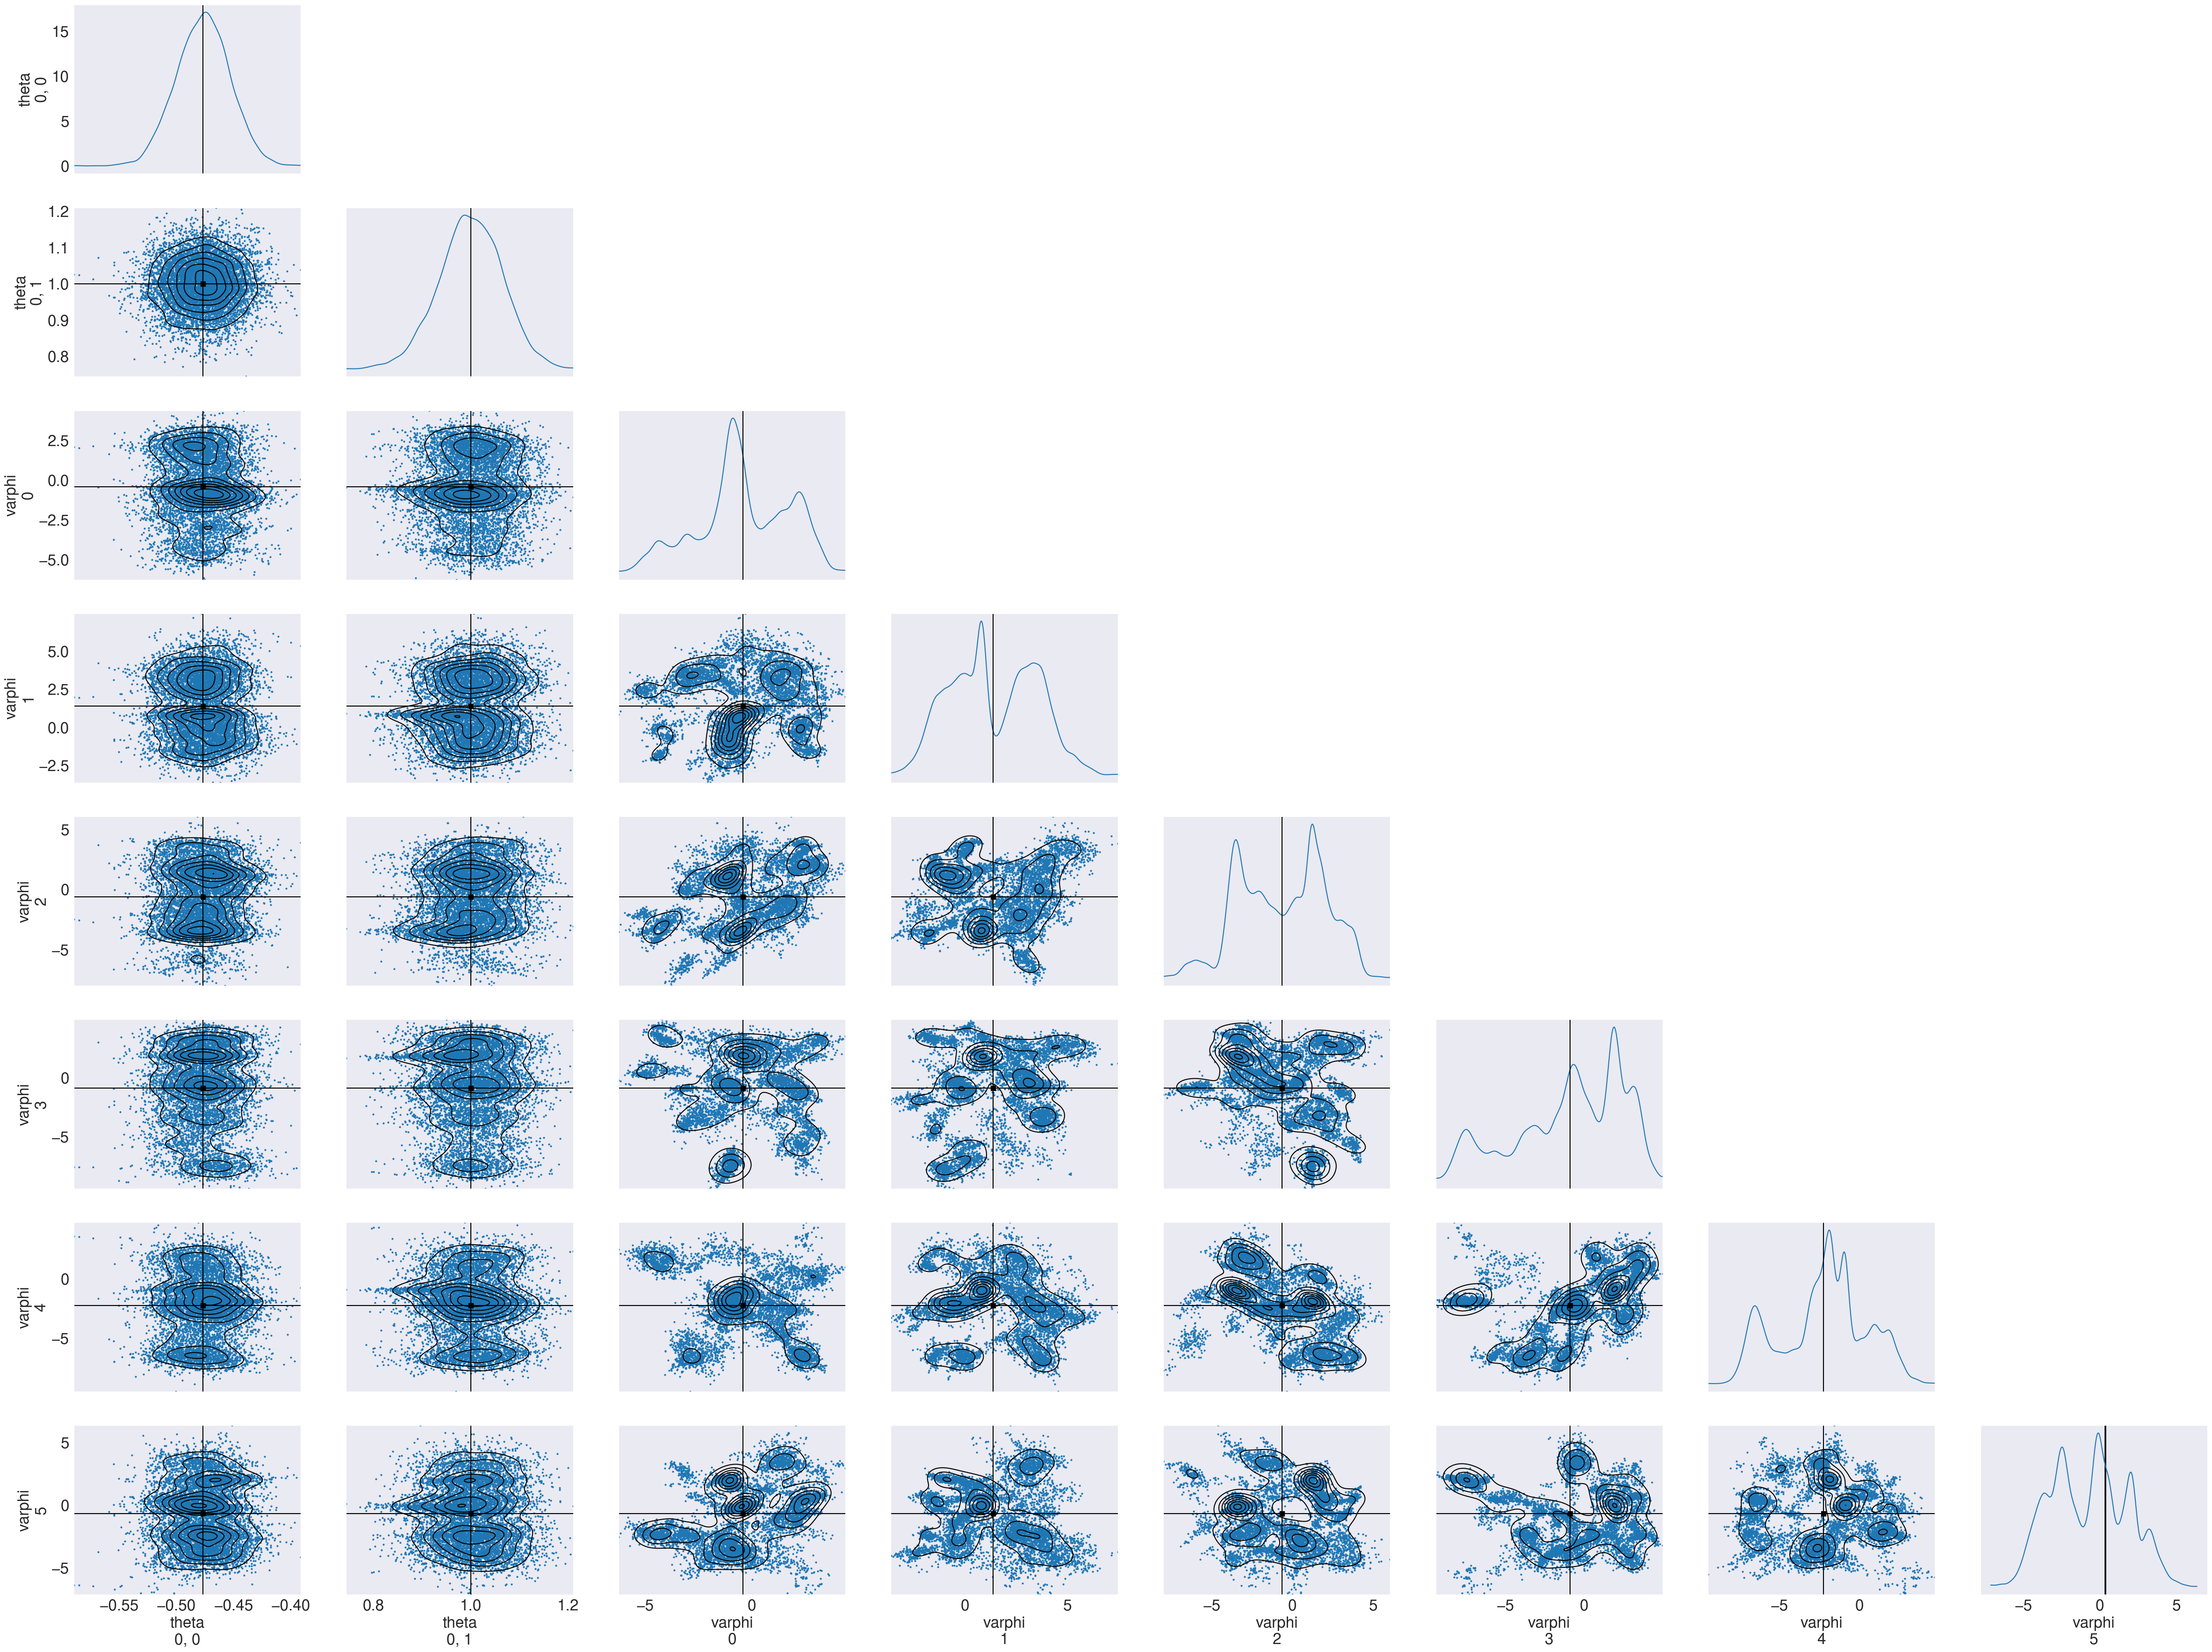

In [35]:
az.plot_pair(az_post_hmc_12,
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="mean",)

#### Load samples and model

In [14]:
# load samples
wandb_curve_exp_id = '8fi94h7m'
exp_id = 'ocdxcqdf'
exp_col.num_bends = 13
art = wandb.Api().artifact(f'ddold/semi_regression_v2/data_{exp_id}:v0')
az_post_hmc_12 = az.from_netcdf(art.file())

# load model state
art = wandb.Api().artifact(f'ddold/semi_regression_v2/model_state_{exp_id}:v0')
base_model = getModel(RegNet, seed=exp_col.seed, **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(device=device)
num_dnn_params = np.sum([p.numel() for p in base_model.dnn.parameters()])
pyro_model_12 = pyroSemiSubspace(
    mean=torch.zeros(num_dnn_params, device=device, dtype=torch.float32),
    cov_factor=torch.zeros((exp_col.num_bends-1, num_dnn_params), device=device, dtype=torch.float32),
    sequential_dnn=base_model.dnn,
    module_structure=base_model.structure_lin,
    outcome_dist=exp_col.nll_fn.dist_)
pyro_model_12.load_state_dict(torch.load(art.file()))

# convert arviz samples back for pyro model
# samples = az_post_hmc.posterior.rename({
#         'theta' :'structure_nn.weight',
#         'theta_dim_0' :'structure_nn.weight_dim_0',
#         'theta_dim_1' :'structure_nn.weight_dim_1'})
# samples_pyro = {}
# for name in samples.data_vars:
#     var_samples = samples[name].to_numpy()
#     shape = (np.prod(var_samples.shape[:2]), *var_samples.shape[2:])
#     var_samples = var_samples.reshape(shape)
#     samples_pyro[name] = torch.from_numpy(var_samples).to(device=device)
pyro_model_12
test_lppd_k12 = wandb.Api().run(f'ddold/semi_regression_v2/{exp_id}').summary['test_lppd']
test_lppd_k12

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10


SemiAdditive
RegNet


463.3284912109375

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

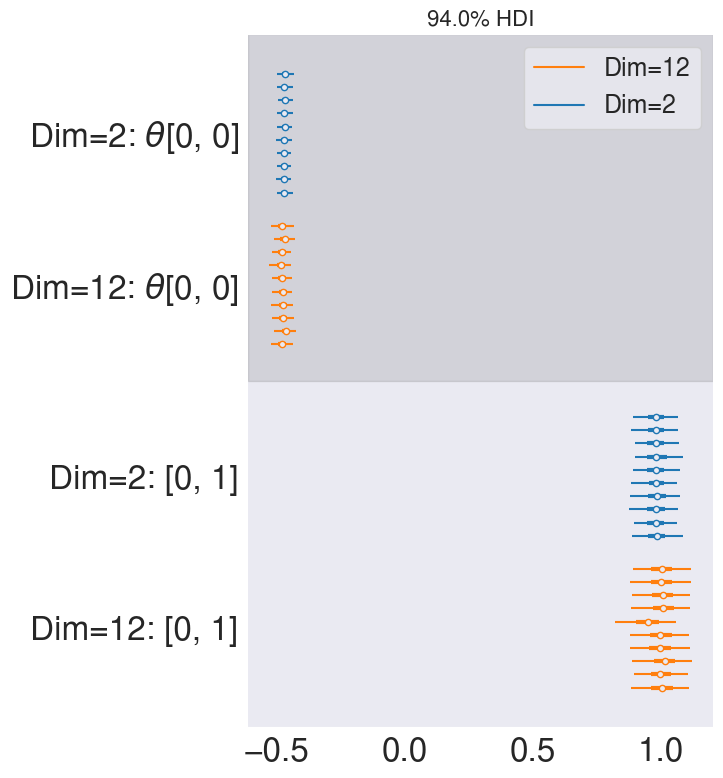

In [36]:
labeller = az.labels.MapLabeller(var_name_map={"theta": r"$\theta$", "varphi": r"$\varphi$"})
az.plot_forest([az_post_hmc, az_post_hmc_12], model_names=['Dim=2', 'Dim=12'], var_names='theta', labeller=labeller)

/tmp/ipykernel_983986/3808989283.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


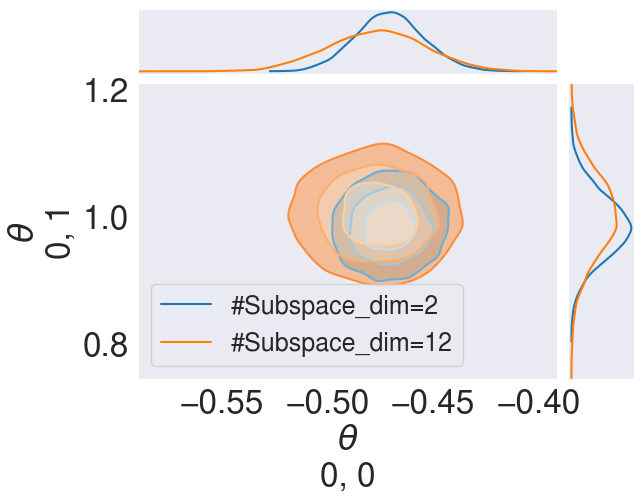

In [37]:
axes = az.plot_pair(az_post_hmc, 
    var_names="theta", 
    labeller=labeller, 
    marginals=True, 
    kind='kde', 
    marginal_kwargs={'color':sns.color_palette()[0]}, 
    kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75],
                    contour_kwargs={"colors":sns.color_palette('tab20c')[:4]},
                    contourf_kwargs={"alpha":0.5, 'colors':sns.color_palette('tab20c')[:4]}))
az.plot_pair(az_post_hmc_12, 
             var_names="theta", 
             labeller=labeller, 
             marginals=True, 
             kind='kde', 
             ax=axes, 
             marginal_kwargs={'color':sns.color_palette()[1]}, 
             kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75], 
                             contour_kwargs={"colors":sns.color_palette('tab20c')[4:8]},
                             contourf_kwargs={"alpha":0.5, 'colors':(sns.color_palette('tab20c')[4:8])}))
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color=sns.color_palette()[0], label='#Subspace_dim=2')
orange_line = mlines.Line2D([], [], color=sns.color_palette()[1], label='#Subspace_dim=12')
axes[1][0].legend(handles=[blue_line, orange_line], loc='lower left')
plt.tight_layout()

array([[<Axes: title={'center': 'theta\n0, 0'}>,
        <Axes: title={'center': 'theta\n0, 0'}>],
       [<Axes: title={'center': 'theta\n0, 1'}>,
        <Axes: title={'center': 'theta\n0, 1'}>],
       [<Axes: title={'center': 'varphi\n0'}>,
        <Axes: title={'center': 'varphi\n0'}>],
       [<Axes: title={'center': 'varphi\n1'}>,
        <Axes: title={'center': 'varphi\n1'}>]], dtype=object)

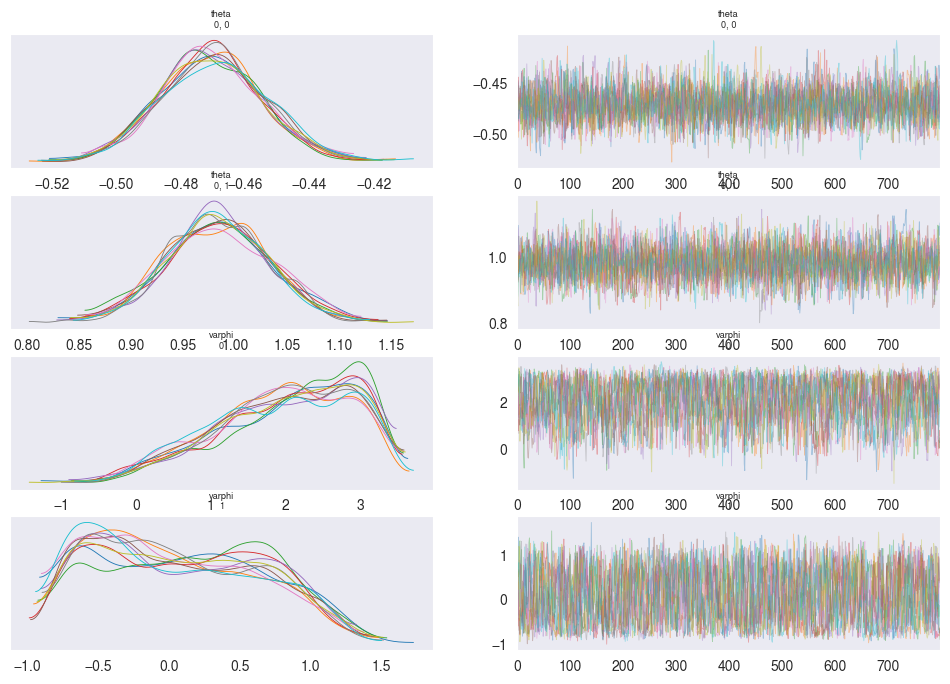

In [38]:
az.plot_trace(az_post_hmc, compact=False)

array([[<Axes: title={'center': 'theta\n0, 0'}>,
        <Axes: title={'center': 'theta\n0, 0'}>],
       [<Axes: title={'center': 'theta\n0, 1'}>,
        <Axes: title={'center': 'theta\n0, 1'}>],
       [<Axes: title={'center': 'varphi\n0'}>,
        <Axes: title={'center': 'varphi\n0'}>],
       [<Axes: title={'center': 'varphi\n1'}>,
        <Axes: title={'center': 'varphi\n1'}>],
       [<Axes: title={'center': 'varphi\n2'}>,
        <Axes: title={'center': 'varphi\n2'}>],
       [<Axes: title={'center': 'varphi\n3'}>,
        <Axes: title={'center': 'varphi\n3'}>],
       [<Axes: title={'center': 'varphi\n4'}>,
        <Axes: title={'center': 'varphi\n4'}>],
       [<Axes: title={'center': 'varphi\n5'}>,
        <Axes: title={'center': 'varphi\n5'}>],
       [<Axes: title={'center': 'varphi\n6'}>,
        <Axes: title={'center': 'varphi\n6'}>],
       [<Axes: title={'center': 'varphi\n7'}>,
        <Axes: title={'center': 'varphi\n7'}>],
       [<Axes: title={'center': 'varphi\n8

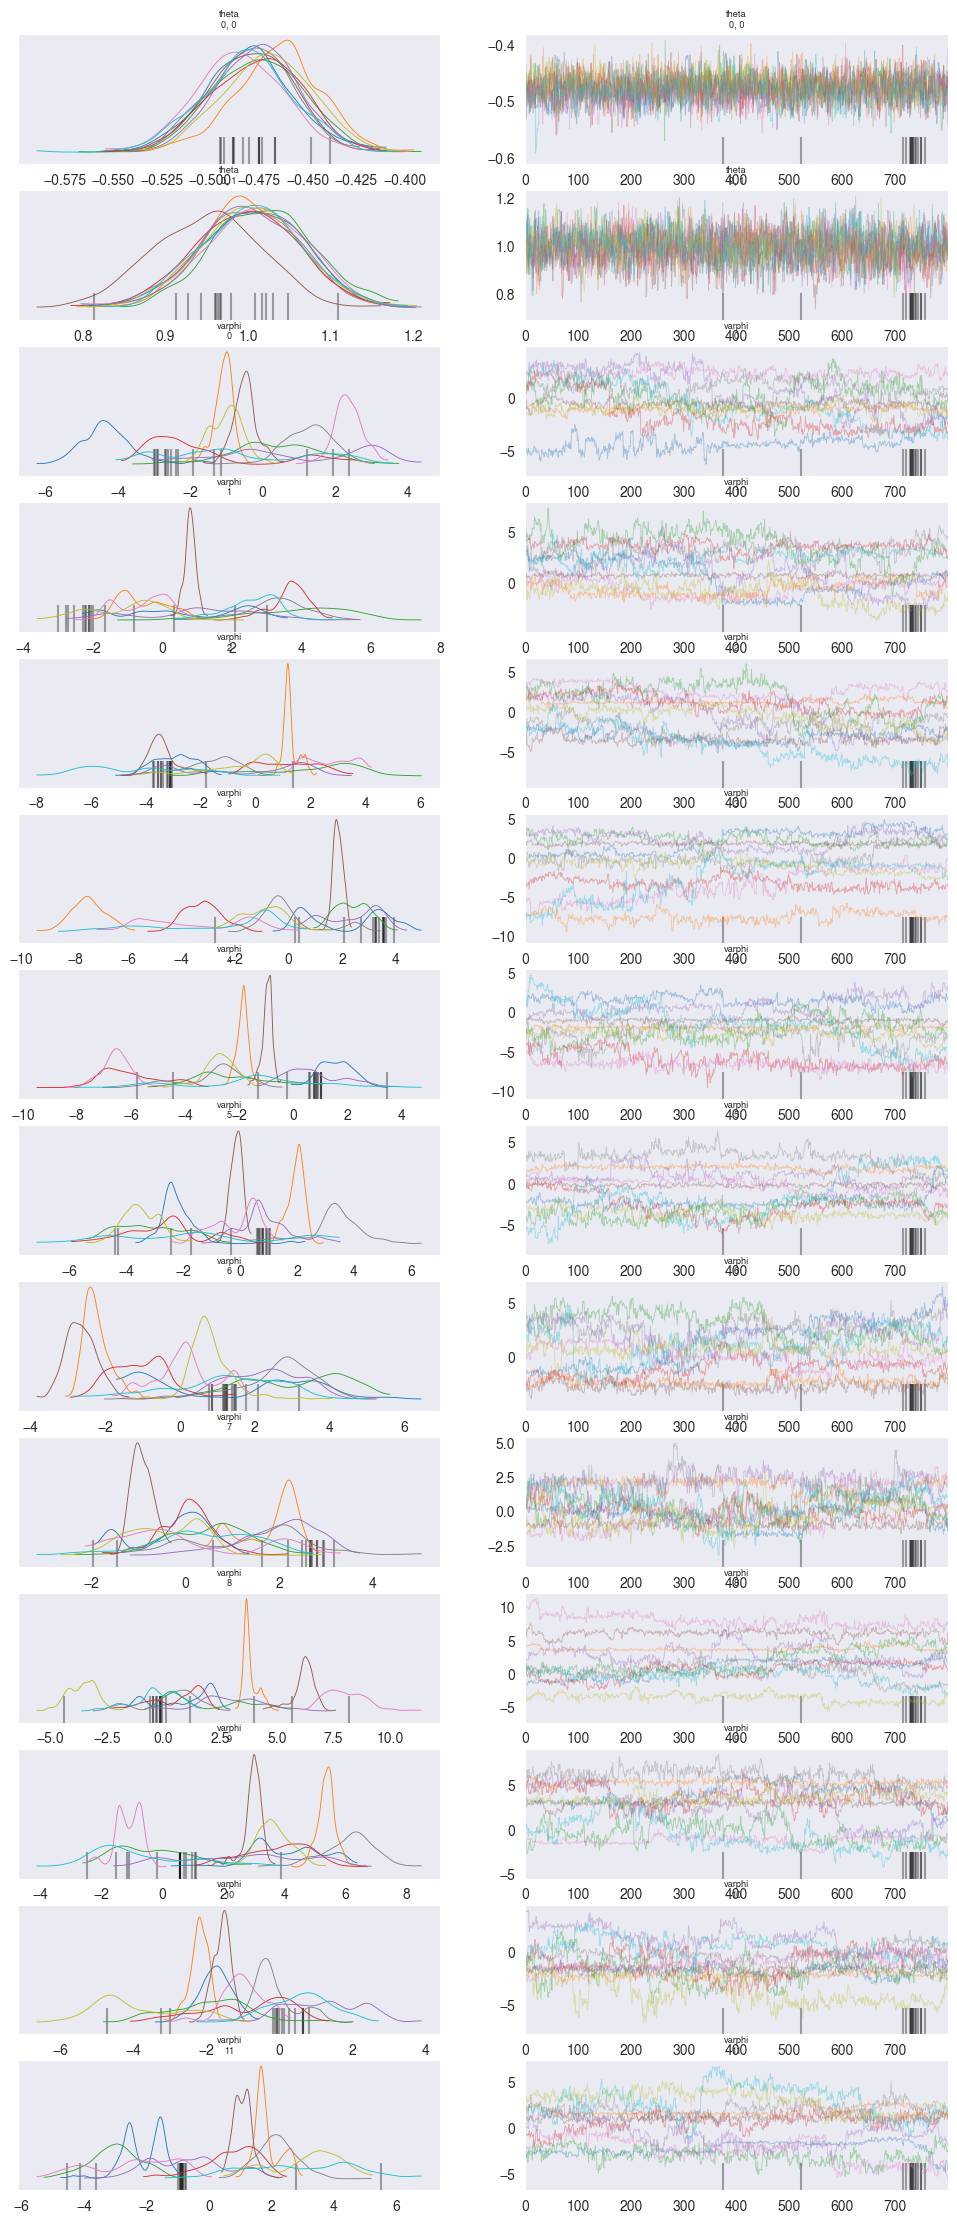

In [39]:
az.plot_trace(az_post_hmc_12, compact=False)

## Fullspace comparision

In [24]:
from jax import numpy as jnp
from numpyro import distributions as np_dist
import jax
import numpyro
from numpyro.infer.initialization import init_to_sample as np_init_to_sample
from src.pyro_models import NumpyroModel
from jax.scipy.special import logsumexp
from numpyro import handlers

def fullspace_hmc(num_warmup, num_samples, num_chains, exp_col):
    # -> data preparation <-
    unp, xnp, ynp = exp_col.train_dataloader.dataset[:]
    unp = jnp.array(unp.cpu().numpy().astype(np.float32))
    xnp = jnp.array(xnp.cpu().numpy().astype(np.float32))
    ynp = jnp.array(ynp.cpu().numpy().astype(np.float32))


    outcome_dist = np_dist.Normal  # outcome distributions
    constrain_fn = {'loc': lambda x: x}
    dist_kwargs = {'scale': .05}
    base_net_kwargs_g = exp_col.base_net_kwargs

    # -> inference loop <-
    model = NumpyroModel(dist=outcome_dist,
                        base_net_kwargs=base_net_kwargs_g,
                        constrains=constrain_fn,
                        **dist_kwargs)
    prng = jax.random.PRNGKey(exp_col.seed + 1)
    kernel = numpyro.infer.NUTS(model,
                                step_size=1e-5,
                                adapt_step_size=True,
                                adapt_mass_matrix=True,
                                dense_mass=True,
                                init_strategy=np_init_to_sample,
                                target_accept_prob=0.6)
    mcmc = numpyro.infer.MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        chain_method="parallel",
        progress_bar=True,
    )
    # mcmc.warmup(prng, unp, xnp, ynp, extra_fields=("diverging", "adapt_state.step_size", 'accept_prob','potential_energy', 'energy', 'r'), collect_warmup=True)
    # mcmc.run(prng, unp, xnp, ynp, extra_fields=("diverging", "adapt_state.step_size", 'accept_prob','potential_energy', 'energy', 'r', "num_steps"))
    mcmc.run(prng, unp, xnp, ynp, extra_fields=['energy', "num_steps"])

    # -> analyze results <-
    posterior_samples = mcmc.get_samples()
    posterior_predictive = numpyro.infer.Predictive(model, posterior_samples)(
        jax.random.PRNGKey(1), unp, xnp
    )
    prior = numpyro.infer.Predictive(model, num_samples=500)(
        jax.random.PRNGKey(2), unp, xnp
    )
    mcmc_data = az.from_numpyro(
        mcmc,
        prior=prior,
        posterior_predictive=posterior_predictive,
        log_likelihood=False
    )
    # save in wandb
    wandb_logger = WandbLogger(project=exp_col.wandb_project, log_model=False,
                                name=f'hmc_Fullspace_{wandb_curve_exp_id}',
                                group="Fullspace", resume='never')
    fname = "az_hmc_fullspace_posterior.nc"
    mcmc_data.to_netcdf(fname)
    art = wandb.Artifact(f"data_{wandb_logger.experiment.id}", type="xarray",
                            description="posterior, posterior predictive and prior predictive with HMC\nReload with from_netcdf('fname')")
    art.add_file(fname)
    wandb_logger.experiment.log_artifact(art)

    # compute valid lppd
    if exp_col.valid_dataloader is not None:
        unp_t, xnp_t, ynp_t = exp_col.valid_dataloader.dataset[:]
        unp_t = jnp.array(unp_t.cpu().numpy().astype(np.float32))
        xnp_t = jnp.array(xnp_t.cpu().numpy().astype(np.float32))
        ynp_t = jnp.array(ynp_t.cpu().numpy().astype(np.float32))
        log_likelihood = numpyro.infer.util.log_likelihood(handlers.seed(model, prng), posterior_samples, unp_t, xnp_t,
                                                            y=ynp_t)
        lppd = (logsumexp(log_likelihood['y'], axis=0) - np.log(log_likelihood['y'].shape[0])).sum()
        wandb_logger.experiment.summary["valid_lppd"] = lppd.item()

    # compute test lppd
    if exp_col.test_dataloader is not None:
        unp_t, xnp_t, ynp_t = exp_col.test_dataloader.dataset[:]
        unp_t = jnp.array(unp_t.cpu().numpy().astype(np.float32))
        xnp_t = jnp.array(xnp_t.cpu().numpy().astype(np.float32))
        ynp_t = jnp.array(ynp_t.cpu().numpy().astype(np.float32))
        log_likelihood = numpyro.infer.util.log_likelihood(handlers.seed(model, prng), posterior_samples, unp_t, xnp_t,
                                                            y=ynp_t)
        lppd = (logsumexp(log_likelihood['y'], axis=0) - np.log(log_likelihood['y'].shape[0])).sum()
        wandb_logger.experiment.summary["test_lppd"] = lppd.item()

    # plot posterior with ground truth
    labeller = az.labels.MapLabeller(var_name_map={"theta": r"$\theta$", "varphi": r"$\varphi$"})
    axes = az.plot_posterior(mcmc_data, var_names=("theta",), labeller=labeller,
                                backend_kwargs={'layout': 'tight'})
    wandb_logger.experiment.log({'Coverage_comparison': wandb.Image(plt.gcf())})

    # plot trace plot
    az.plot_trace(mcmc_data, var_names=("theta"), compact=False, labeller=labeller,
                    backend_kwargs={'layout': 'tight'})
    wandb_logger.experiment.log({'Trace plot': wandb.Image(plt.gcf())})

    # Description
    summary_subspace = az.summary(mcmc_data)
    wandb_logger.experiment.log({"description": wandb.Table(dataframe=summary_subspace.reset_index())})
    max_r_hat = az.rhat(mcmc_data, var_names='theta')['theta'].to_numpy().max()
    wandb_logger.experiment.summary["r_hat_max_structure"] = max_r_hat
    r_hat_smaller_1_1 = max_r_hat < 1.1
    wandb_logger.experiment.summary["r_hat<1.1"] = r_hat_smaller_1_1
    wandb_logger.experiment.config.update({'num_chains': num_chains,
                                            'num_warmup': num_warmup,
                                            'num_samples': num_samples,
                                            'seed': exp_col.seed,
                                            'dist': outcome_dist,
                                            'Subspace_dimension': exp_col.num_bends - 1})
    mcmc.print_summary()
    return mcmc, mcmc_data, wandb_logger

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

wandb: Currently logged in as: ddold. Use `wandb login --relogin` to force relogin



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
      nn.Dense_0.bias[0]     -0.60      0.72     -0.58     -1.75      0.61     11.92      1.48
      nn.Dense_0.bias[1]     -0.01      1.03     -0.11     -1.61      1.77      7.50      2.21
      nn.Dense_0.bias[2]     -0.26      0.65     -0.25     -1.23      0.89     13.13      1.45
      nn.Dense_0.bias[3]     -0.50      0.84     -0.35     -2.03      0.72      8.40      1.83
      nn.Dense_0.bias[4]     -0.37      0.83     -0.24     -1.71      0.93      7.75      1.88
      nn.Dense_0.bias[5]      0.16      0.81      0.06     -1.10      1.48      8.80      1.76
      nn.Dense_0.bias[6]     -0.02      0.63      0.00     -1.13      0.97     14.22      1.39
      nn.Dense_0.bias[7]      0.21      0.65      0.16     -0.88      1.24     11.50      1.54
      nn.Dense_0.bias[8]     -0.07      0.90      0.05     -1.53      1.38      7.84      1.96
      nn.Dense_0.bias[9]     -0.22      0.74     

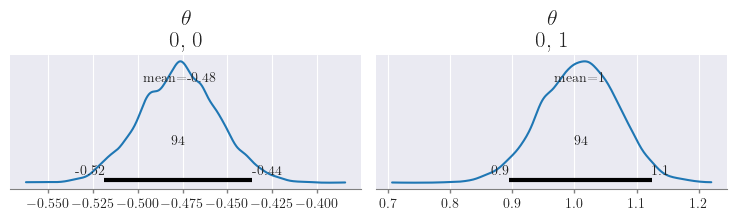

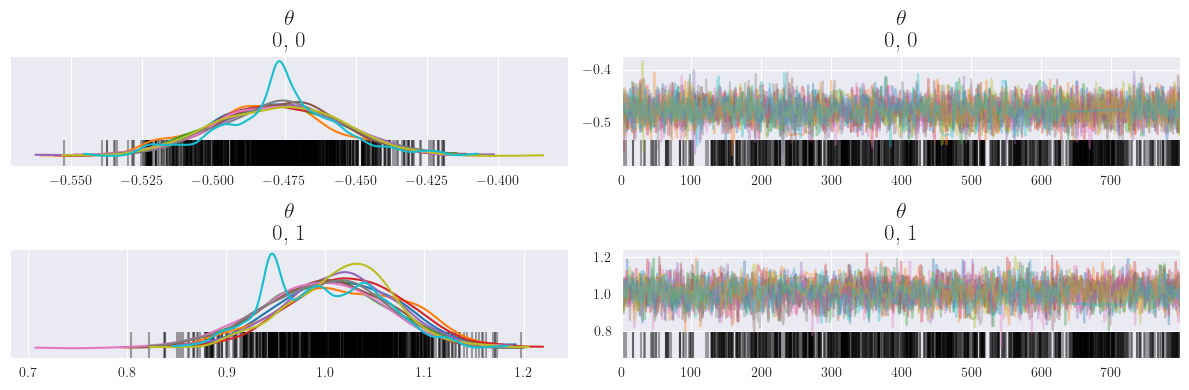

In [25]:
mcmc_full, az_mcmc_samples_full, wandb_logger_full = fullspace_hmc(num_warmup=400, 
                                                             num_samples=800, 
                                                             num_chains=10, 
                                                             exp_col=exp_col)
wandb.finish()

## Compare posterior

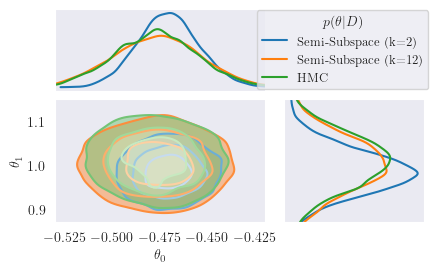

In [41]:
labeller = az.labels.MapLabeller(var_name_map={"theta": r"$\theta$", "varphi": r"$\varphi$"})
gs_kw = dict(height_ratios=[figsize[0]*0.4, figsize[0]*0.6], width_ratios=[figsize[1]*0.6, figsize[1]*0.4])
fig6, f6_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(figsize[0]*1.3, figsize[1]*1.3),
        gridspec_kw=gs_kw)
axes = az.plot_pair(az_post_hmc, 
    var_names="theta", 
    labeller=labeller, 
    marginals=True, 
    kind='kde', 
    figsize=figsize,
    ax=f6_axes,
    marginal_kwargs={'color':sns.color_palette()[0]}, 
    kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75],
                    contour_kwargs={"colors":sns.color_palette('tab20c')[:4]},
                    contourf_kwargs={"alpha":0.5, 'colors':sns.color_palette('tab20c')[:4]}))
axes = az.plot_pair(az_post_hmc_12, 
             var_names="theta", 
             labeller=labeller, 
             marginals=True, 
             kind='kde', 
             figsize=figsize,
             ax=axes, 
             marginal_kwargs={'color':sns.color_palette()[1]}, 
             kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75], 
                             contour_kwargs={"colors":sns.color_palette('tab20c')[4:8]},
                             contourf_kwargs={"alpha":0.5, 'colors':(sns.color_palette('tab20c')[4:8])}))
axes = az.plot_pair(az_mcmc_samples_full, 
             var_names="theta", 
             labeller=labeller, 
             marginals=True, 
             kind='kde',
             figsize=figsize, 
             ax=axes, 
             marginal_kwargs={'color':sns.color_palette()[2]}, 
             kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75], 
                             contour_kwargs={"colors":sns.color_palette('tab20c')[8:12]},
                             contourf_kwargs={"alpha":0.5, 'colors':(sns.color_palette('tab20c')[8:12])}))

import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color=sns.color_palette()[0], label='Semi-Subspace (k=2)')
orange_line = mlines.Line2D([], [], color=sns.color_palette()[1], label='Semi-Subspace (k=12)')
green_line = mlines.Line2D([], [], color=sns.color_palette()[2], label='HMC')
fig6.legend(handles=[blue_line, orange_line, green_line], loc='outside upper right', bbox_to_anchor=(1., .98,), bbox_transform=fig6.transFigure, mode=None, borderaxespad=0., title=r'$p(\boldsymbol{\theta}|\mathcal{D})$')
axes[1][0].set_xlabel(r'$\theta_0$')
axes[1][0].set_ylim(0.87,1.15)
axes[1][0].set_xlim(-0.53,-0.42)
axes[1][1].set_ylim(0.87,1.15)
axes[0][0].set_xlim(-0.53,-0.42)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])
axes[1][0].set_ylabel(r'$\theta_1$')
plt.savefig("figures2/regression_posterior_zu_fig1.pdf")

### check predictive performance

(-2.5, 3.0)

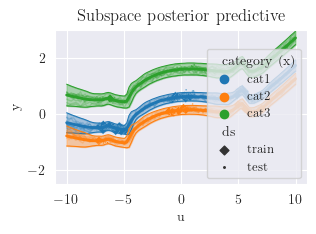

In [46]:
from pyro.infer import Predictive
pyro.clear_param_store()

u_predictive = np.linspace(-10, 10, 100)
u_predictive_t = (features(u_predictive) - exp_col.f_mean) / exp_col.f_std
u_predictive_t = torch.from_numpy(u_predictive_t.astype(np.float32)).to(device=device)
samples = az_post_hmc.posterior.rename({
        'theta' :'structure_nn.weight',
        'theta_dim_0' :'structure_nn.weight_dim_0',
        'theta_dim_1' :'structure_nn.weight_dim_1'})
samples_pyro = {}
for name in samples.data_vars:
    var_samples = samples[name].to_numpy()
    shape = (np.prod(var_samples.shape[:2]), *var_samples.shape[2:])
    var_samples = var_samples.reshape(shape)
    samples_pyro[name] = torch.from_numpy(var_samples).to(device=device)
posterior_predictive = Predictive(pyro_model, samples_pyro)

meta_zero = torch.zeros_like(u_predictive_t)
post_pred_samples_00 = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()
meta_zero[:,0] = 1.
post_pred_samples_01 = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()
meta_zero[:,0] = 0.
meta_zero[:,1] = 1.
post_pred_samples_10 = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()

plot_data(exp_col)
def plot_samples(x_axis, preds, ax, color='blue'):
    mu = preds.mean(0)
    sigma = preds.std(0)

    ax.plot(x_axis, mu, "-", lw=2., color=color)
    ax.plot(x_axis, mu - 3 * sigma, "-", lw=0.75, color=color)
    ax.plot(x_axis, mu + 3 * sigma, "-", lw=0.75, color=color)

    np.random.shuffle(preds)
    for traj in preds[:10]:
        ax.plot(x_axis, traj, "-", alpha=.25, color=color, lw=1.)

    ax.fill_between(x_axis, mu - 3 * sigma, mu + 3 * sigma, alpha=0.35, color=color)

plot_samples(u_predictive, post_pred_samples_00, ax=plt.gca(), color=sns.color_palette()[0])
plot_samples(u_predictive, post_pred_samples_01, ax=plt.gca(), color=sns.color_palette()[1])
plot_samples(u_predictive, post_pred_samples_10, ax=plt.gca(), color=sns.color_palette()[2])
plt.title("Subspace posterior predictive")
plt.ylim(-2.5,3)

(-2.5, 3.0)

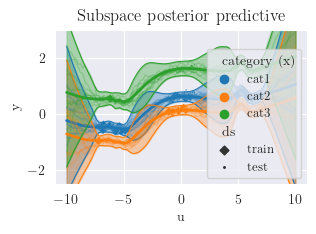

In [47]:
pyro.clear_param_store()

u_predictive = np.linspace(-10, 10, 100)
u_predictive_t = (features(u_predictive) - exp_col.f_mean) / exp_col.f_std
u_predictive_t = torch.from_numpy(u_predictive_t.astype(np.float32)).to(device=device)
samples = az_post_hmc_12.posterior.rename({
        'theta' :'structure_nn.weight',
        'theta_dim_0' :'structure_nn.weight_dim_0',
        'theta_dim_1' :'structure_nn.weight_dim_1'})
samples_pyro = {}
for name in samples.data_vars:
    var_samples = samples[name].to_numpy()
    shape = (np.prod(var_samples.shape[:2]), *var_samples.shape[2:])
    var_samples = var_samples.reshape(shape)
    samples_pyro[name] = torch.from_numpy(var_samples).to(device=device)
posterior_predictive = Predictive(pyro_model_12, samples_pyro)

meta_zero = torch.zeros_like(u_predictive_t)
post_pred_samples_00_12 = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()
meta_zero[:,0] = 1.
post_pred_samples_01_12 = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()
meta_zero[:,0] = 0.
meta_zero[:,1] = 1.
post_pred_samples_10_12 = posterior_predictive(u_predictive_t, meta_zero)['obs'].detach().cpu().numpy()

plot_data(exp_col)
def plot_samples(x_axis, preds, ax, color='blue'):
    mu = preds.mean(0)
    sigma = preds.std(0)

    ax.plot(x_axis, mu, "-", lw=2., color=color)
    ax.plot(x_axis, mu - 3 * sigma, "-", lw=0.75, color=color)
    ax.plot(x_axis, mu + 3 * sigma, "-", lw=0.75, color=color)

    np.random.shuffle(preds)
    for traj in preds[:10]:
        ax.plot(x_axis, traj, "-", alpha=.25, color=color, lw=1.)

    ax.fill_between(x_axis, mu - 3 * sigma, mu + 3 * sigma, alpha=0.35, color=color)

plot_samples(u_predictive, post_pred_samples_00_12, ax=plt.gca(), color=sns.color_palette()[0])
plot_samples(u_predictive, post_pred_samples_01_12, ax=plt.gca(), color=sns.color_palette()[1])
plot_samples(u_predictive, post_pred_samples_10_12, ax=plt.gca(), color=sns.color_palette()[2])
plt.title("Subspace posterior predictive")
plt.ylim(-2.5,3)

(-2.5, 3.0)

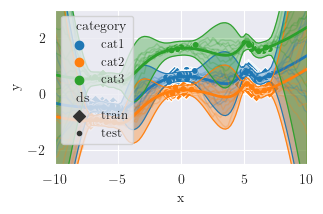

In [48]:
xx = jnp.array(u_predictive)
predictive = numpyro.infer.Predictive(mcmc_full.sampler.model, mcmc_full.get_samples(), parallel=True)

prng = jax.random.PRNGKey(1)
meta = jnp.zeros((len(xx), 2))
preds_mcmc_1 = predictive(prng, (features(xx)-f_mean)/f_std, meta)['y']
meta = meta.at[:,0].set(1.)
preds_mcmc_2 = predictive(prng, (features(xx)-f_mean)/f_std, meta)['y']
meta = jnp.zeros((len(xx), 2))
meta = meta.at[:,1].set(1.)
preds_mcmc_3 = predictive(prng, (features(xx)-f_mean)/f_std, meta)['y']
fig = plt.figure()
ax = fig.gca()
df_combine = pd.concat([df,df_test], axis=0, keys=['train','test'], names=["ds"]).reset_index(0)
sns.scatterplot(data=df_combine['data'], x='x', y='y', hue='category', hue_order=exp_col.hue_order, style=df_combine['ds'], markers=['D','.'], s=100, ax=ax)
plot_samples(u_predictive, np.array(preds_mcmc_1), ax=ax, color=sns.color_palette()[0])
plot_samples(u_predictive, np.array(preds_mcmc_2), ax=ax, color=sns.color_palette()[1])
plot_samples(u_predictive, np.array(preds_mcmc_3), ax=ax, color=sns.color_palette()[2])
ax.set_xlim([np.min(u_predictive), np.max(u_predictive)])
ax.set_ylim(-2.5,3.)

In [49]:
def plot_samples(x_axis, preds, ax, color='blue'):
    mu = preds.mean(0)
    sigma = preds.std(0)
    hdi = az.hdi(az.convert_to_dataset(preds[None,:,:], )).x.to_numpy()

    ax.plot(x_axis, mu, "-", lw=2., color=color)
    ax.plot(x_axis, hdi[:,0], "-", lw=0.75, color=color, alpha=0.5)
    ax.plot(x_axis, hdi[:,1], "-", lw=0.75, color=color, alpha=0.5)

    np.random.shuffle(preds)
    for traj in preds[:10]:
        ax.plot(x_axis, traj, "-", alpha=.25, color=color, lw=1.)

    ax.fill_between(x_axis, hdi[:,0], hdi[:,1], alpha=0.35, color=color)

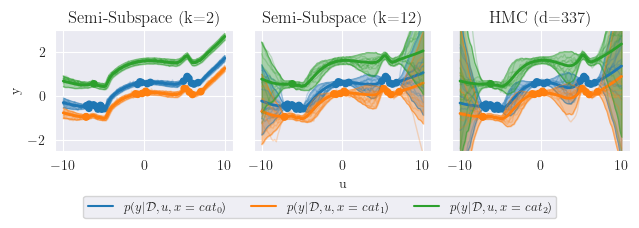

In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyro.infer import Predictive

# Assuming you have already defined the necessary variables and functions
# from your provided code snippets

# Create a figure and a FacetGrid
fig, axes = plt.subplots(1, 3, figsize=[figsize[0]*2, figsize[1]*1.05], sharex=True, sharey=True)

# Define a function to plot the samples on the subplot
def plot_subplot_samples(ax, u_predictive, post_pred_cat1, post_pred_cat2, post_pred_cat3, title, color_palette=sns.color_palette()):
    plot_samples(u_predictive, post_pred_cat1, ax=ax, color=color_palette[0])
    plot_samples(u_predictive, post_pred_cat2, ax=ax, color=color_palette[1])
    plot_samples(u_predictive, post_pred_cat3, ax=ax, color=color_palette[2])
    ax.set_title(title)  # Set the title for each subplot

plot_subplot_samples(axes.flatten()[0], u_predictive, post_pred_samples_00, post_pred_samples_01, post_pred_samples_10, title="Semi-Subspace (k=2)")
plot_subplot_samples(axes.flatten()[1], u_predictive, post_pred_samples_00_12, post_pred_samples_01_12, post_pred_samples_10_12, title="Semi-Subspace (k=12)")
plot_subplot_samples(axes.flatten()[2], u_predictive, np.array(preds_mcmc_1), np.array(preds_mcmc_2), np.array(preds_mcmc_3), title=f"HMC (d={num_dnn_params})")

# Set common labels and limits
axes[0].set_ylabel("y")
axes[1].set_xlabel("u")
axes[0].set_ylim(-2.5, 3)


# sns.scatterplot(data=df_combine['data'], x='x', y='y', hue='category', hue_order=exp_col.hue_order, style=df_combine['ds'], markers=['D','.'], size=df_combine['ds'], sizes=(10, 50), ax=axes.flatten()[0])
# sns.scatterplot(data=df['data'], x='x', y='y', hue='category', hue_order=exp_col.hue_order, ax=axes.flatten()[0], s=50)
from pandas.api.types import CategoricalDtype
cat_dtype = CategoricalDtype(categories=exp_col.hue_order, ordered=True)
colormap = [sns.color_palette()[i] for i in df['data']['category'].astype(cat_dtype).cat.codes.to_numpy()]
axes[0].scatter(x=df['data']['x'], y=df['data']['y'], c=colormap, s=20)
axes[1].scatter(x=df['data']['x'], y=df['data']['y'], c=colormap, s=20)
axes[2].scatter(x=df['data']['x'], y=df['data']['y'], c=colormap, s=20)


# legend_labels = ["Label 1", "Label 2", "Label 3"]  # Replace with your legend labels
# legend_colors = plt.cm.get_cmap('Set1')(np.arange(3))
# legend_ax = fig.add_axes([0.85, 0.5, 0.1, 0.3])  # Adjust position and size as needed
# legend_ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10, label=label) for col, label in zip(legend_colors, legend_labels)])
# legend_ax.axis('off')

import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color=sns.color_palette()[0],
                          markersize=15, label=r'$p(y|\mathcal{D},u,x=cat_0)$')
orange_line = mlines.Line2D([], [], color=sns.color_palette()[1],
                          markersize=15, label=r'$p(y|\mathcal{D},u,x=cat_1)$')
green_line = mlines.Line2D([], [], color=sns.color_palette()[2],
                          markersize=15, label=r'$p(y|\mathcal{D},u,x=cat_2)$')
fig.legend(handles=[blue_line, orange_line, green_line], loc='outside lower center', bbox_to_anchor =(.5,-0.09), ncols=3)
# fig.legend(loc='outside lower center')
# plt.legend(loc='outside lower center')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig("figures2/fig1.pdf", bbox_inches='tight')

In [21]:
# plot mean lppd
test_lppd_hmc = wandb.Api().run(f'ddold/semi_regression_v2/9akbnil8').summary['test_lppd']
test_lppd_hmc
pd.options.display.float_format = '{:20,.2f}'.format
print(pd.DataFrame({'Sem-Subspace (k=2)': [test_lppd_k2/len(df_test),], 'Sem-Subspace (k=12)': [test_lppd_k12/len(df_test),], 'HMC': [test_lppd_hmc/len(df_test),]}))

    Sem-Subspace (k=2)  Sem-Subspace (k=12)                  HMC
0                 1.14                 1.27                 1.26


In [22]:
len(df_test)

365